# Modeling Volatility with GARCH Models
Project 4 focuses on conditional heteroskedasticity, a phenomenon caused when an increase in volatility is correlated with a further increase in volatility.


## 1. Volatility
In finance, volatility is synonymous with risk. It has a significant impact on risk management where it is used to calculate metrics such as *portfolio risk*, *sharpe ratio*, and many others covered in [Project 1](../Project1/CAPM%20copy.ipynb) and [Project 2](../Project2/FiveFactorModel.ipynb).

In this Project we will be covering a selection of **GARCH** (**G**eneralized **A**utoregressive **C**onditional **H**eteroskedasticity) models - both univariate and multivariate - which are one of the most popular ways of modeling volatility.

## 2.1. Explaining Stock Returns' Volatility with ARCH models
The logic underlying of the ARCH method is in the following equations:

$$\begin{align}
    r_t &= \mu + \varepsilon_t \tag*{(2.1.)}\\
\end{align}$$
$$\begin{align}
    \tag*{(2.2.)}
    \varepsilon_t &= \sigma_t z_t \\
\end{align}$$
$$\begin{align}
    \tag*{(2.3.)}
    \sigma_t^2  &= \omega + \sum_{i=1}^q \alpha_i\varepsilon_{t-i}^2
\end{align}$$


Equation $(2.1.)$ represents the return series as a combination of the expected return $\mu$ and the expected return $\varepsilon_t$, where $\varepsilon_t$ has **white noise** properties - meaning it has a zero mean, so returns are only described by the residuals $r_t = \varepsilon_t$.

Equation $(2.2.)$ represents the error series in terms of a stochastic component $z_t \sim N(0,1)$ and a conditional standard deviation $\sigma_t$ (governing the typical size of the residuals).

Finally, equation $(2.3.)$ is the ARCH formula.

Now we apply ARCH model to Apple's monthly stock returns.
+ The stock asset of choice for this example is `AAPL`. We get the data from Yahoo Finance.
+ Then we calculate the asset's monthly returns.
+ We define the ARCH model using `arch` Python library.
+ Finally we fit the model and plot its results by annualizing the conditional volatility series from monthly data.

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import scipy
from arch import arch_model
import statsmodels as sm
import matplotlib.pyplot as plt
import datetime as dt
import fredpy as fp
from logins import KEY
fp.api_key = KEY


In [2]:
# GET ASSET DATA FROM YAHOO FINANCE
ASSET = '^GSPC'
START_DATE = '1955-1-1'
END_DATE = '2022-1-1'

spx_df = pdr.get_data_yahoo(ASSET, START_DATE, END_DATE, interval= 'm')
spx_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1985-01-01,180.270004,163.360001,167.199997,179.630005,2673710000,179.630005
1985-02-01,183.949997,177.750000,179.630005,181.179993,2194620000,181.179993
1985-03-01,183.889999,176.529999,181.179993,180.660004,2153090000,180.660004
1985-04-01,183.610001,177.860001,180.660004,179.830002,1981880000,179.830002
1985-05-01,189.979996,178.350006,179.830002,189.550003,2350340000,189.550003
...,...,...,...,...,...,...
2021-09-01,4545.850098,4305.910156,4528.799805,4307.540039,66268850000,4307.540039
2021-10-01,4608.080078,4278.939941,4317.160156,4605.379883,61874700000,4605.379883
2021-11-01,4743.830078,4560.000000,4610.620117,4567.000000,67520800000,4567.000000


In [3]:
# LOAD F&F DATA
dateparse = lambda x: dt.datetime.strptime(x,'%Y%m')
ff_df = pd.read_csv('../data/F-F_Research_Data_Factors.CSV',
                        header=0,
                        names=['Date','Mkt-RF','SMB','HML','RF'],
                        parse_dates=['Date'], date_parser=dateparse,
                        index_col=0,
                        skipfooter=99,
                        skiprows=3,
                        engine='python')
ff_df

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-01,2.96,-2.38,-2.73,0.22
1926-08-01,2.64,-1.47,4.14,0.25
1926-09-01,0.36,-1.39,0.12,0.23
1926-10-01,-3.24,-0.13,0.65,0.32
1926-11-01,2.53,-0.16,-0.38,0.31
...,...,...,...,...
2021-09-01,-4.37,0.80,5.09,0.00
2021-10-01,6.65,-2.28,-0.44,0.00
2021-11-01,-1.55,-1.35,-0.53,0.00


Get NBER data for final analysis

In [4]:

nber_df = fp.series('USREC')
nber_df = (nber_df.as_frequency(freq='Q', method='last').data).to_frame()
nber_df.columns = ['nber']
nber_df
#nber_df.plot.area(alpha=0.2, color='gray')

/Users/matteoambrosini/miniforge3/envs/finance/lib/python3.9/site-packages/fredpy/__init__.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.data = pd.Series([],pd.to_datetime([]))
/Users/matteoambrosini/miniforge3/envs/finance/lib/python3.9/site-packages/fredpy/__init__.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.data = pd.Series([],pd.to_datetime([]))


,nber
date,
1854-10-01,1.0
1855-01-01,0.0
1855-04-01,0.0
1855-07-01,0.0
1855-10-01,0.0
...,...
2021-01-01,0.0
2021-04-01,0.0
2021-07-01,0.0


<AxesSubplot:title={'center':'^GSPC returns: 1955-1-1 - 2022-1-1'}, xlabel='Date'>

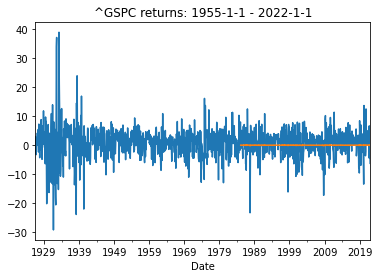

In [5]:
# CALCULATE MONTHLY RETURNS
spx_rets = spx_df['Adj Close'].pct_change().dropna()
spx_rets.name = 'asset_returns'

# CALCULATE MONTHLY RETURNS FOR F&F
ff_rets = ff_df['Mkt-RF']
ff_rets.name = 'ff_returns'


ff_rets.plot(title='Fama&French returns')
spx_rets.plot(title=f'{ASSET} returns: {START_DATE} - {END_DATE}')



In [58]:
# ARCH MODEL WITH 'Zero' mean and 'Constant' mean
RETURNS = ff_rets
zero_mean_arch_model = arch_model(RETURNS, mean='Zero', vol='ARCH', p=1, o=0, q=0, rescale=True).fit(disp='off')
print(zero_mean_arch_model.summary())
# const_mean_model = arch_model(asset_rets, mean='Constant', vol='ARCH', p=1, o=0, q=0).fit(disp='off')
# print(const_mean_model.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:             ff_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -3516.09
Distribution:                  Normal   AIC:                           7036.18
Method:            Maximum Likelihood   BIC:                           7046.27
                                        No. Observations:                 1147
Date:                Sun, Apr 17 2022   Df Residuals:                     1147
Time:                        19:57:21   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega         23.3642      2.643      8.840  9.576e-19   [ 18.18

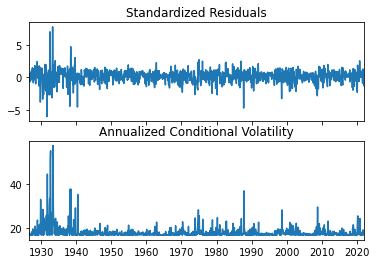

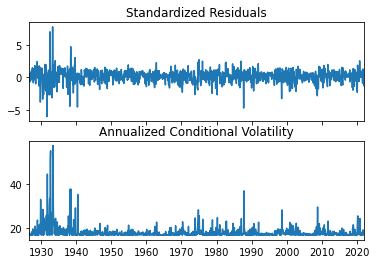

In [59]:
# PLOT RESIDUALS
zero_mean_arch_model.plot(annualize='M')
#plt.ylim(top=6, bottom=-6)

## 2.2. Explaining Stock Returns' Volatility with GARCH models
Compared to the ARCH model used in Section 2, GARCH additionally adds the moving average part of the AR component.

The equation for GARCH model is as follows:

$$\begin{align}
    \tag*{(3.1.)}
    r_t &= \mu + \varepsilon_t \\
\end{align}$$
$$\begin{align}
    \tag*{(3.2.)}
    \varepsilon_t &= \sigma_t z_t \\
\end{align}$$
$$\begin{align}
    \tag*{(3.3.)}
    \sigma_t^2  &= \omega + \sum_{i=1}^q \alpha_i\varepsilon_{t-i}^2 + \sum_{i=1}^p \beta_i\sigma_{t-i}^2
\end{align}$$

In equation $(3.3.)$:
+ $p$ is the number of lag variances, and
+ $q$ is the number of lag residual errors from a mean process.

Intuitively, a GARCH(0,$q$) model is equivalent to an ARCH($q$) model.

In [60]:
# SPECIFY THE `Zero` mean and `Constant` mean GARCH MODEL
zero_mean_garch_model = arch_model(RETURNS, mean='Zero', vol='GARCH', p=1, o=0, q=1, rescale=False)
#const_mean_garch_model = arch_model(asset_rets, mean='Constant', vol='GARCH', p=1, o=0, q=1, rescale=False)

In [61]:
# ESTIMATE THE zero_mean_garch_model AND PRINT RESULTS
zero_mean_garch_model = zero_mean_garch_model.fit(disp='off')
zero_mean_garch_model.summary()
#const_mean_garch_model = const_mean_garch_model.fit(disp='off')
#const_mean_garch_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:             ff_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -3398.99
Distribution:                  Normal   AIC:                           6803.97
Method:            Maximum Likelihood   BIC:                           6819.11
                                        No. Observations:                 1147
Date:                Sun, Apr 17 2022   Df Residuals:                     1147
Time:                        19:57:29   Df Model:                            0
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.7171      0.270      2.659  7.840e-03   [  0.189,  1.246]
alpha[1]       0.1273  2.121e-02      6.003  1.939e-09 [8.576e-02,  0.169]
beta[1]        0.8508  2.148e-02     39.609      0.000   [  0.809,  0.893]
==========================================================================

Covariance estimator: robust
"""

In [10]:
# const_mean_garch_model.conditional_volatility.mean()
# const_mean_garch_model.conditional_volatility.var()

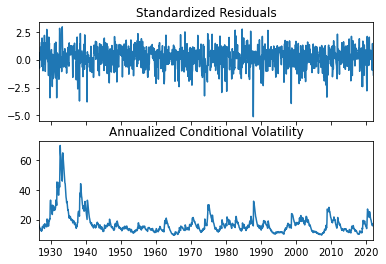

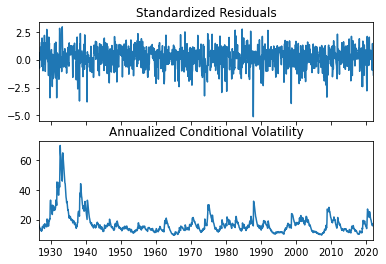

In [62]:
# PLOT RESIDUALS
zero_mean_garch_model.plot(annualize='M')
# const_mean_garch_model.plot(annualize='M')

```
Plot the conditional variance and volatility of Market Excess Returns. What is the mean and standard deviation of volatility?
```

mean:  4.242094982292649
standard deviaiton:  1.4881737452109338


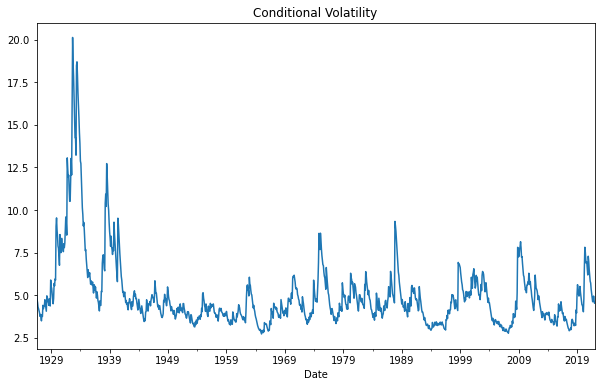

In [70]:
import math
zero_mean_garch_model.conditional_volatility.plot(title='Conditional Volatility', figsize=(10,6))
#make data annual by multiplying by sqrt(12)
print('mean: ',zero_mean_garch_model.conditional_volatility.loc['2018-01-01':'2020-01-01'].mean())#)
print('standard deviaiton: ',zero_mean_garch_model.conditional_volatility.loc['2018-01-01':'2020-01-01'].var()*(math.sqrt(12)))

```
Do conditional volatility of mkt_excess_ret have any predictive power for recessions in a simple or dynamic probit model?
```

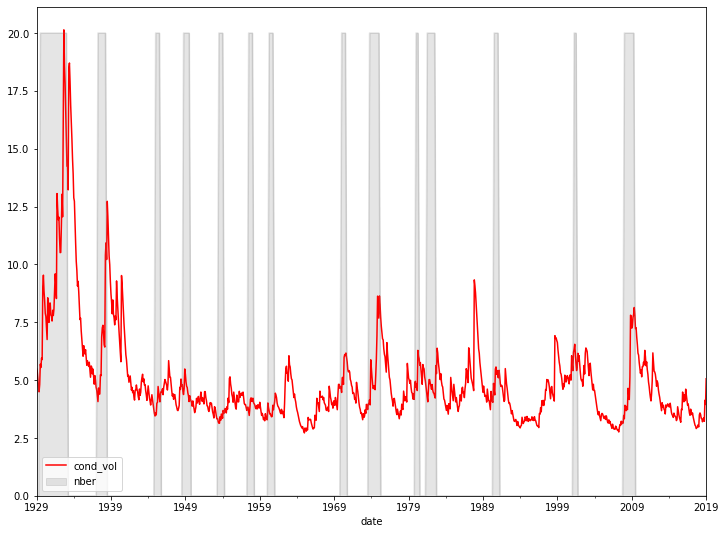

In [13]:
# GARCH model 
excess_ret_garch_model = arch_model(ff_rets, mean='Zero', vol='GARCH', p=1, o=0, q=1, rescale=False).fit(disp='off')
mkt_excess_ret_cond_vol = excess_ret_garch_model.conditional_volatility

# plotting results
fig, ax = plt.subplots(figsize=(12,9))
mkt_excess_ret_cond_vol.loc['1929-01-01':'2019-01-01'].plot.line(ax=ax, color='red')
(nber_df*20).loc['1929-01-01':'2019-01-01'].plot.area(ax=ax, alpha=0.2, color='gray')
plt.legend()

Importing data for `mkt_excess_rets`, `term`, `federal_funds`, `nber`.

In [14]:
# market excess return = `ff_rets`
ff_rets
# TERM = treasury_10y - treasury_3m
treasury_10y_series = fp.series('DGS10',).as_frequency(freq='Q', method='last')  # treasury 10Y
treasury_3m_series = fp.series('TB3MS',)     # treasury 3m
term_series = (treasury_10y_series.data - treasury_3m_series.data).dropna()
term_df = term_series.to_frame()
term_df.columns = ['term']
term_df

# FEDERAL FUNDS
fed_funds_rate_series = fp.series('FEDFUNDS').as_frequency(freq='Q', method='last')
fed_funds_rate_df = (fed_funds_rate_series.data).to_frame()
fed_funds_rate_df.columns = ['fed_funds']
fed_funds_rate_df

# MERGING INTO SINGLE DATAGRAME
params = pd.merge(
    pd.merge(pd.merge(ff_rets, term_df, left_index=True, right_index=True),
                    fed_funds_rate_df, left_index=True, right_index=True),
                    nber_df, left_index=True, right_index=True)
params

/Users/matteoambrosini/miniforge3/envs/finance/lib/python3.9/site-packages/fredpy/__init__.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.data = pd.Series([],pd.to_datetime([]))
/Users/matteoambrosini/miniforge3/envs/finance/lib/python3.9/site-packages/fredpy/__init__.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.data = pd.Series([],pd.to_datetime([]))
/Users/matteoambrosini/miniforge3/envs/finance/lib/python3.9/site-packages/fredpy/__init__.py:276: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.data = pd.Series([],pd.to_datetime([]))
/Users/matteoambrosini/miniforge3/envs/finance/lib/python3.9/site-packages/fred

,ff_returns,term,fed_funds,nber
1962-01-01,-3.87,1.14,2.85,0.0
1962-04-01,-6.59,1.27,2.68,0.0
1962-07-01,6.28,1.02,2.90,0.0
1962-10-01,-0.05,1.11,2.93,0.0
1963-01-01,4.93,1.04,2.98,0.0
...,...,...,...,...
2021-01-01,-0.03,1.66,0.07,0.0
2021-04-01,4.93,1.43,0.08,0.0
2021-07-01,1.27,1.47,0.08,0.0
2021-10-01,6.65,1.47,0.08,0.0


In [15]:
# Generating one GARCH model per param
ff_rets_garch = arch_model(params.ff_returns, mean='Zero', vol='GARCH', p=1, o=0, q=1, rescale=False).fit(disp='off')
term_garch = arch_model(params.term, mean='Zero', vol='GARCH', p=1, o=0, q=1, rescale=False).fit(disp='off')
fed_funds_garch = arch_model(params.fed_funds, mean='Zero', vol='GARCH', p=1, o=0, q=1, rescale=False).fit(disp='off')

# Save Conditional Volatility for each param
ff_rets_cv = ff_rets_garch.conditional_volatility
term_garch_cv = term_garch.conditional_volatility
fed_funds_cv =fed_funds_garch.conditional_volatility

cond_vols = pd.merge(
    pd.merge(ff_rets_cv, term_garch_cv, left_index=True, right_index=True),
            fed_funds_cv, left_index=True, right_index=True
)
cond_vols.columns = ['ff_returns','term','fed_funds']
all_data = cond_vols.join(params.nber, on=cond_vols.index)
all_data

,ff_returns,term,fed_funds,nber
1962-01-01,4.505739,1.166451,4.612716,0.0
1962-04-01,4.574831,1.280638,2.850660,0.0
1962-07-01,5.112048,1.385860,2.680702,0.0
1962-10-01,5.343236,1.251232,2.900649,0.0
1963-01-01,4.826128,1.277666,2.930642,0.0
...,...,...,...,...
2021-01-01,5.622224,1.046689,0.108918,0.0
2021-04-01,5.011031,1.622446,0.093076,0.0
2021-07-01,5.037110,1.558349,0.100812,0.0
2021-10-01,4.655676,1.571969,0.100812,0.0


In [16]:
def norm_distr(value):
    value = scipy.stats.norm.cdf(value, 0.0, 1.0)
    return value

In [17]:
def probit_model (x, y, prediction_lag=5, plot=True):
    '''
    Runs probit model.
    '''
    # x = cond_vols['fed_funds']
    # y = params.nber
    data = pd.concat([x.shift(prediction_lag), y], axis=1)
    data = data.iloc[prediction_lag :, :]

    X = data.iloc[:, 0]
    y = data.iloc[:, 1]
    X = sm.api.add_constant(X)
    model = sm.discrete.discrete_model.Probit(y, X).fit(disp='off')
    fitted_values = model.fittedvalues

    data['recession_probability'] = norm_distr(fitted_values)

    if plot == True:
        # plotting results
        fig, ax = plt.subplots()
        data.recession_probability.plot.line(ax=ax, figsize=(16,8), color='red')
        data.nber.plot.area(ax=ax, figsize=(16,8), color='gray', alpha=0.2)
        plt.legend()
        ax.set_ylabel('Probability')
        ax.set_title('Recession Prediction for {} {} in advance'.format(prediction_lag, ('quarter' if prediction_lag == 1 else 'quarters')))
    
    return model

```
Do conditional volatility of excess market return have any predictive power for recessions in a simple or dynamic probit model?
```

Optimization terminated successfully.
         Current function value: 0.360204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.356862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.363927
  

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                   nber   No. Observations:                  230
Model:                         Probit   Df Residuals:                      228
Method:                           MLE   Df Model:                            1
Date:                Sat, 16 Apr 2022   Pseudo R-squ.:                 0.01554
Time:                        22:41:26   Log-Likelihood:                -83.862
converged:                       True   LL-Null:                       -85.186
Covariance Type:            nonrobust   LLR p-value:                    0.1037
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0041      0.527     -3.801      0.000      -3.037      -0.971
ff_returns     0.1644      0.101      1.634      0.102      -0.033       0.362
==============================================================================
"""

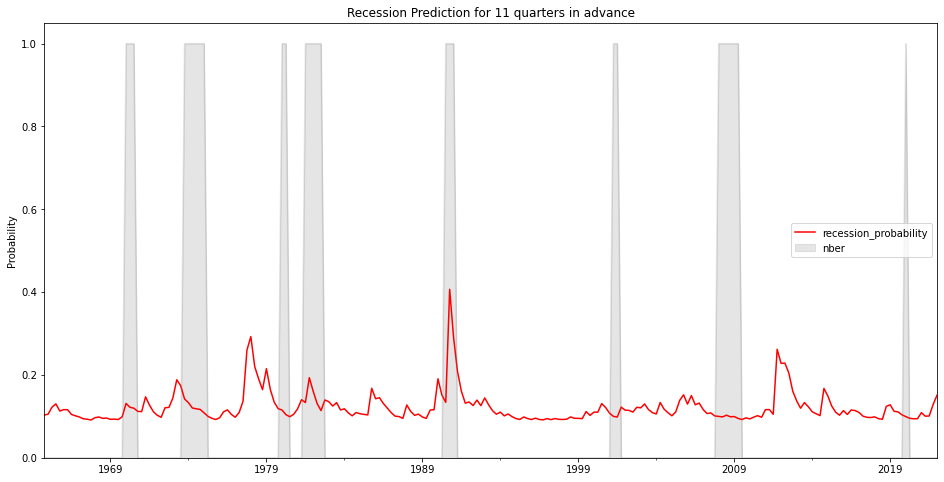

In [53]:
# market_rets_pred_power = probit_model(x=all_data.ff_returns, y=all_data.nber, prediction_lag=10)
summary = {
    'lag' : [],
    'r_squared' : [],
}

for i in range(1,13):
    model = probit_model(x=all_data.ff_returns, y=all_data.nber, prediction_lag=i, plot=False)
    summary['lag'].append(i)
    summary['r_squared'].append(model.prsquared)
summary = pd.DataFrame(summary)
summary.set_index = 'lag'
best_lag = summary['r_squared'].idxmax()

best_market_pred = probit_model(x=all_data.ff_returns, y=all_data.nber, prediction_lag=best_lag, plot=True)
best_market_pred.summary()

```
Do conditional volatility of TERM have any predictive power for recessions in a simple or dynamic probit model?
```

Optimization terminated successfully.
         Current function value: 0.314179
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.305983
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.320366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364097
  

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                   nber   No. Observations:                  240
Model:                         Probit   Df Residuals:                      238
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 Apr 2022   Pseudo R-squ.:                  0.1278
Time:                        20:22:27   Log-Likelihood:                -75.403
converged:                       True   LL-Null:                       -86.455
Covariance Type:            nonrobust   LLR p-value:                 2.581e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0122      0.297      0.041      0.967      -0.570       0.594
term          -0.8006      0.206     -3.891      0.000      -1.204      -0.397
==============================================================================
"""

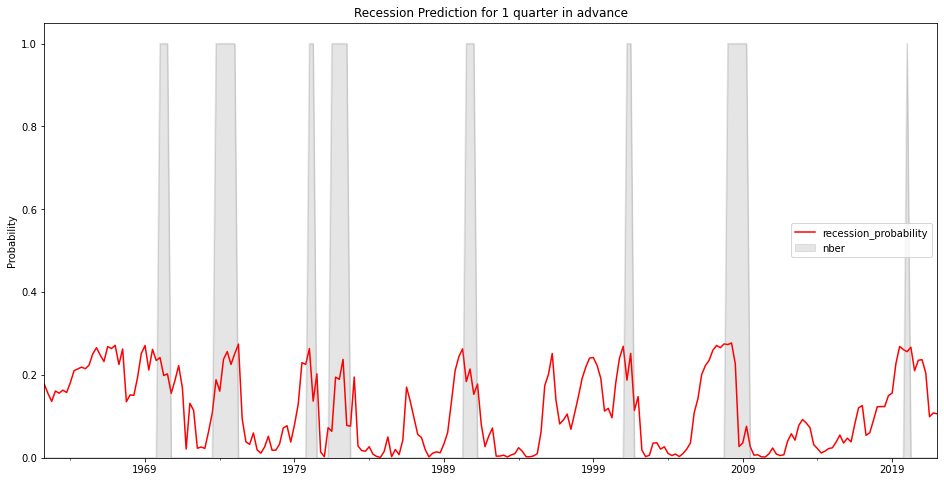

In [75]:
summary = {
    'lag' : [],
    'r_squared' : [],
}

for i in range(1,13):
    model = probit_model(x=all_data.term, y=all_data.nber, prediction_lag=i, plot=False)
    summary['lag'].append(i)
    summary['r_squared'].append(model.prsquared)
summary = pd.DataFrame(summary)
summary.set_index = 'lag'
best_lag = summary['r_squared'].idxmax()

best_market_pred = probit_model(x=all_data.term, y=all_data.nber, prediction_lag=best_lag, plot=True)
best_market_pred.summary()

```
Do conditional volatility of Federal Funds rate have any predictive power for recessions in a simple or dynamic probit model?
```

Optimization terminated successfully.
         Current function value: 0.301677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.295945
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.304377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.316013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.326390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356157
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366409
  

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                   nber   No. Observations:                  240
Model:                         Probit   Df Residuals:                      238
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 Apr 2022   Pseudo R-squ.:                  0.1625
Time:                        20:22:06   Log-Likelihood:                -72.402
converged:                       True   LL-Null:                       -86.455
Covariance Type:            nonrobust   LLR p-value:                 1.149e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0810      0.225     -9.246      0.000      -2.522      -1.640
fed_funds      0.1461      0.029      5.008      0.000       0.089       0.203
==============================================================================
"""

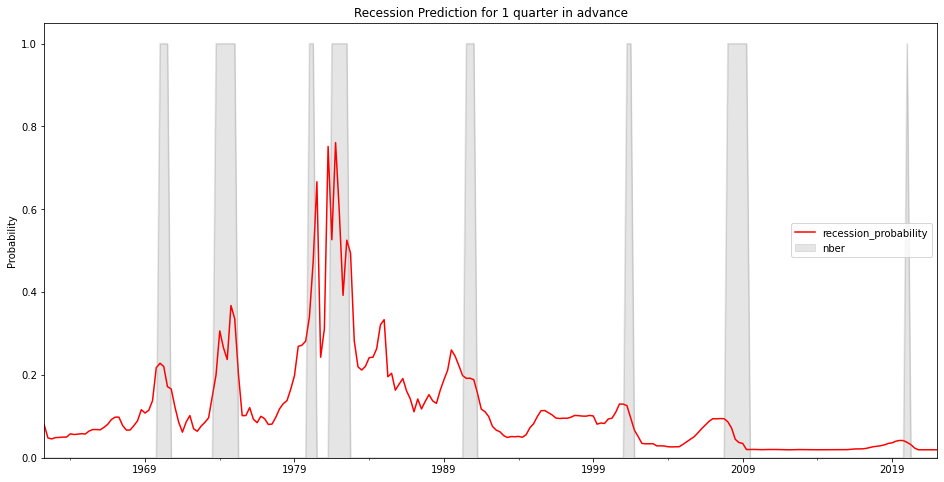

In [74]:
summary = {
    'lag' : [],
    'r_squared' : [],
}

for i in range(1,13):
    model = probit_model(x=all_data.fed_funds, y=all_data.nber, prediction_lag=i, plot=False)
    summary['lag'].append(i)
    summary['r_squared'].append(model.prsquared)
summary = pd.DataFrame(summary)
summary.set_index = 'lag'
best_lag = summary['r_squared'].idxmax()

best_market_pred = probit_model(x=all_data.fed_funds, y=all_data.nber, prediction_lag=best_lag, plot=True)
best_market_pred.summary()